Thanks to:
    
    https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0#.xfoj98vjg

In [1]:
import gym
import numpy as np

In [3]:
env = gym.make('FrozenLake-v0')

[2017-02-19 10:29:48,925] Making new env: FrozenLake-v0


## Q-Table Learning
We have 4 actions and 4x4 states so out Q function will be a 16x4 table.
Each value in the table will be updated according to the bullman equation wich state that the value of the current state is equal to the immediate reward for taking action a plus the discounted reward from the resulting next state. Since we use the current Q function estimate the current states value it is called a bootstrap method.
Q-Learning is an off policy metod because we dont care wich actual action we take in the next state. We take the future value of the action with highest value (argmax). We say the the policy is greedy with respect to the current value function.

In [21]:
#Init table
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Hyper parameters
lr = .85
y  = .99
num_episodes = 2000 # num rollouts

#total reward per episode
rList = []
for i in range(num_episodes):
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    # Max 100 timesteps
    while j < 99:
        j += 1
        # Select action from Q with noise
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n) * (1./(i+1)))
        s1,r,d,_ = env.step(a)
        #Update Q table
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
        rList.append(rAll)

In [23]:
print("Score over time: ", sum(rList)/num_episodes)

Score over time:  0.0


In [24]:
print("Final Q-Table Values")
print(Q)

Final Q-Table Values
[[  1.09811484e-02   2.92040261e-01   3.92972647e-02   4.56913023e-02]
 [  9.10465535e-04   3.17291823e-03   2.91884849e-03   2.92065008e-01]
 [  6.80590290e-03   4.06709559e-03   1.23774110e-02   2.10128624e-01]
 [  9.10544090e-05   3.47211261e-03   5.95750880e-04   1.73455756e-01]
 [  5.44336510e-01   0.00000000e+00   1.25817548e-03   1.25524339e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.46492507e-02   4.04964426e-04   9.82102667e-05   9.23534577e-06]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.46038110e-03   7.74087634e-03   2.67218660e-03   7.67967114e-01]
 [  1.18997772e-02   6.92725197e-01   4.97505233e-03   9.19890236e-03]
 [  8.03191444e-01   6.35338782e-05   4.74298299e-04   8.71956779e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.23225573e-03   3.59030051e-04   4.64936983e-01   4

# Q-Learning with neural networks

Q-learning with function approximators

Big change is that we are not longer directrly updating the table. Instead we a are trying to minimize a loss function.

The loss is the sum of sqyares of Q-target - Q. So we want to minimize the TD-error. Q-target is the bellman update of Q function same as used in the tabular method. r + y(max(Q[s',a'])).

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt

In [26]:
env = gym.make('FrozenLake-v0')

[2017-02-19 11:15:49,320] Making new env: FrozenLake-v0


In [28]:
tf.reset_default_graph()

In [50]:
def fc_layer(input, channels_in, channels_out, name="fc"):
    with tf.name_scope(name):
        W = tf.Variable(tf.random_uniform([channels_in,channels_out],0,.01),name='W')
        tf.summary.histogram("weights", W)
        return tf.matmul(input,W)
    
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32, name="inputs1")
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32,name="nextQ")

Qout = fc_layer(inputs1,16,4,"Qout")

with tf.name_scope("predict"):
    predict = tf.argmax(Qout,1)

with tf.name_scope("loss"):
    loss = tf.reduce_sum(tf.square(nextQ - Qout))

with tf.name_scope("train"):
    trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    updateModel = trainer.minimize(loss)
    
#tf.summary.scalar("loss", loss)

In [51]:
init = tf.global_variables_initializer()

y = .99
e = .1
num_episodes = 2000
jList = [] # steps per episode
rList = [] # total reward per episode
with tf.Session() as sess:
    # All all summary to one op to run
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter("/tmp/rl0/3")
    writer.add_graph(sess.graph)
    sess.run(init)
    for i in range(num_episodes):
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        
        while j < 99:
            j += 1
            # Select action e-greedy?
            a,allQ = sess.run([predict, Qout],
                             feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            
            # Execute action
            s1,r,d,_ = env.step(a[0])
            
            # Get Q values for s1
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            
            # Obtain maxQ and set our target value for chosen action
            maxQ1 = np.max(Q1) #max Q value for s1
            targetQ = allQ     #all Q values for s
            targetQ[0,a[0]] = r + y*maxQ1
            
            if j % 10 == 0:
                s = sess.run(merged_summary, 
                             feed_dict={inputs1:np.identity(16)[s:s+1],
                                      nextQ:targetQ})
                writer.add_summary(s,i+j)
            
            #Train network on target and prediction
            _,W1 = sess.run([updateModel,W],
                           feed_dict={inputs1:np.identity(16)[s:s+1],
                                      nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

InvalidArgumentError: You must feed a value for placeholder tensor 'inputs1_2' with dtype float and shape [1,16]
	 [[Node: inputs1_2 = Placeholder[dtype=DT_FLOAT, shape=[1,16], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'inputs1_2', defined at:
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-2f125b2bd73e>", line 7, in <module>
    inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32, name="inputs1")
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1520, in placeholder
    name=name)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/henke/anaconda2/envs/udacity/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'inputs1_2' with dtype float and shape [1,16]
	 [[Node: inputs1_2 = Placeholder[dtype=DT_FLOAT, shape=[1,16], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


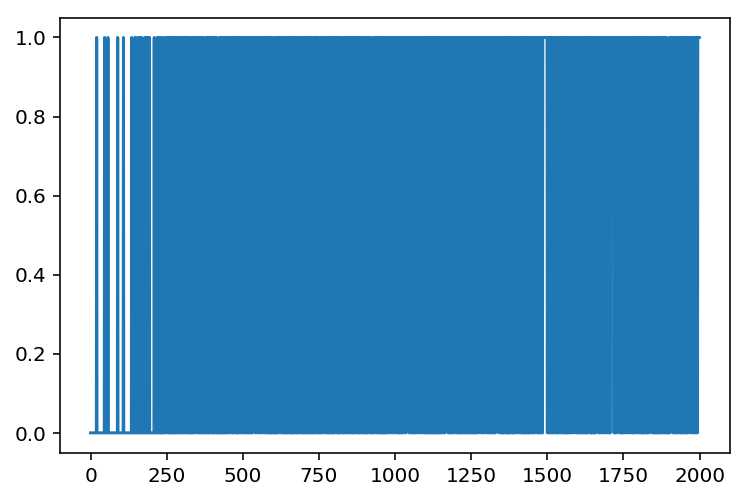

In [34]:
plt.plot(rList)

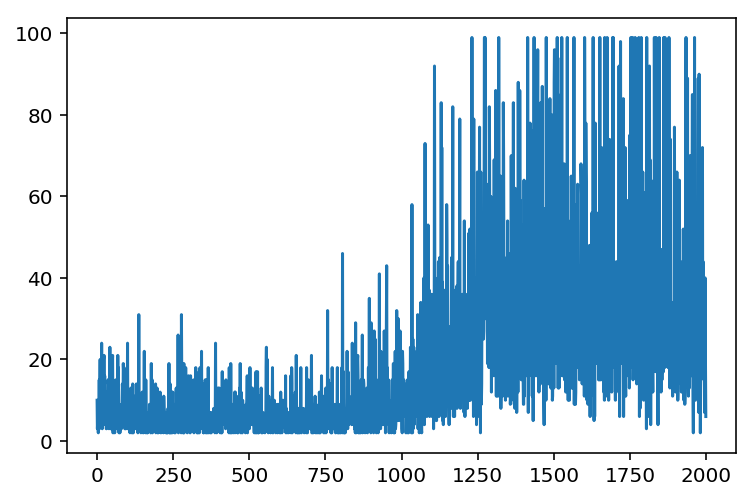

In [40]:
plt.plot(jList)